# Problem Set 4: Harris, SIFT, RANSAC
---
## Setup

In [157]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch
from scipy import ndimage
# Matplotlib params
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

---
## 1. Harris corners
### 1.1 Image Gradients

In [159]:
# Gaussian derivative kernel
def gradX(img):
    kernel = np.array([[-3,  0,  3],
                       [-10, 0, 10],
                       [-3,  0,  3]])
    # grad_img = cv2.filter2D(img, -1, kernel)
    grad_img = ndimage.correlate(img, kernel)
    grad_img /= 16 # Normalize
    return grad_img
    
def gradY(img):
    kernel = np.array([[-3, -10, -3],
                       [0,    0,  0],
                       [3,   10,  3]])
    # grad_img = cv2.filter2D(img, -1, kernel)
    grad_img = ndimage.correlate(img, kernel)
    grad_img /= 16 # Normalize
    return grad_img

def plot_grad(img_dx, img_dy):
    # Plot
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ## Horizontal gradient
    im1 = ax1.imshow(img_dx, vmin=-1, vmax=1)
    ax1.set_title('Gradient (X)')
    ax1.axis('off')
    ## Vertical gradient
    im2 = ax2.imshow(img_dy, vmin=-1, vmax=1)
    ax2.set_title('Gradient (Y)')
    ax2.axis('off')
    plt.subplots_adjust(wspace=0.05)
    fig.colorbar(im2, ax=[ax1, ax2], pad=0.03, shrink=0.8, aspect=15, use_gridspec=True)
    return

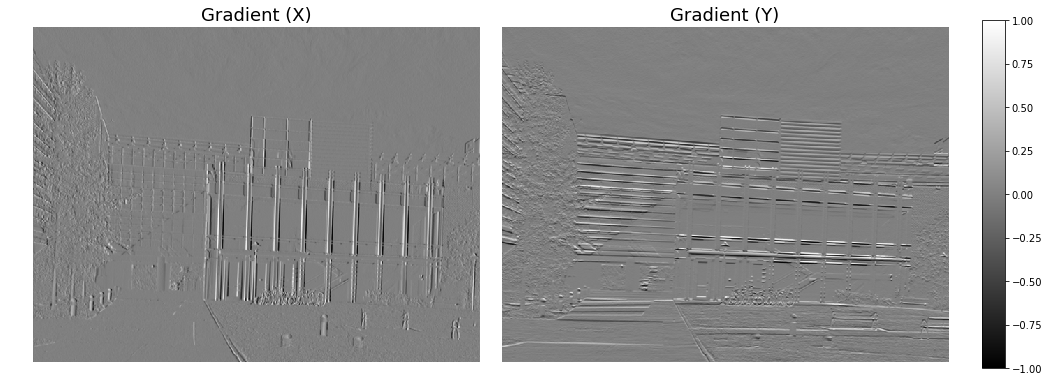

In [160]:
# Load images
## Image A
transA_u8 = cv2.imread('transA.jpg', 0)
transA = transA_u8.astype(np.float) / 255
## Image B
transB_u8 = cv2.imread('transB.jpg', 0)
transB = transB_u8.astype(np.float) / 255
# Calculate Gradients
transA_dx = gradX(transA)
transA_dy = gradY(transA)
# Plot
plot_grad(transA_dx, transA_dy)

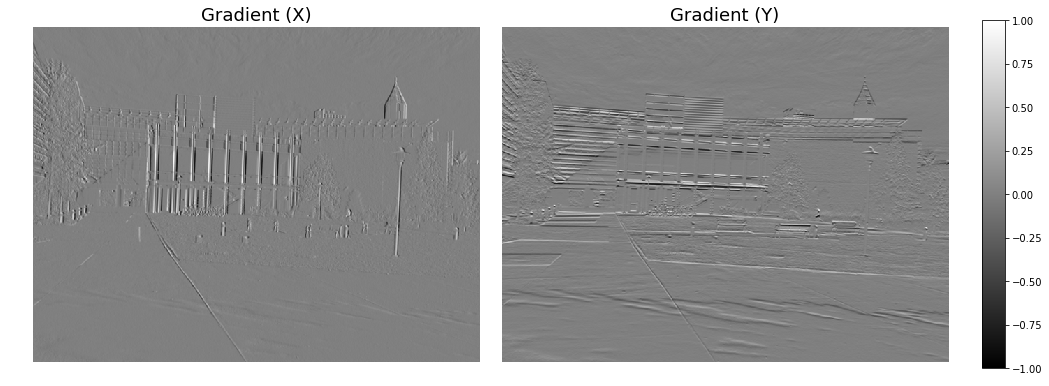

In [161]:
# Load image
## Image A
simA_u8 = cv2.imread('simA.jpg', 0)
simA = simA_u8.astype(np.float) / 255
## Image B
simB_u8 = cv2.imread('simB.jpg', 0)
simB = simB_u8.astype(np.float) / 255
# Calculate Gradients
simA_dx = gradX(simA)
simA_dy = gradY(simA)
# Plot
plot_grad(simA_dx, simA_dy)

### 1.2 Harris Values

In [162]:
def harris_values(img, window_size=None, alpha=0.02):
    '''
    Note: Window Size = 2*int(truncate*sigma + 0.5) + 1
    '''
    # Gradients
    Ix = gradX(img)
    Iy = gradY(img)
    # 2nd Order Moments
    Ixx = Ix*Ix
    Ixy = Ix*Iy
    Iyy = Iy*Iy
    # M matrix
    M11 = ndimage.gaussian_filter(Ixx, sigma=1)
    M22 = ndimage.gaussian_filter(Iyy, sigma=1)
    M12 = ndimage.gaussian_filter(Ixy, sigma=1)
    detM = M11*M22 - M12*M12
    trM = M11 + M22
    # Harris value
    R = detM - alpha*(trM*trM)
    return R

def harris_corners(img, thresh=0.001):
    '''
    
    '''
    def detect_peaks(image):
        '''
        Takes an image and detect the peaks usingthe local maximum filter.
        Returns a boolean mask of the peaks (i.e. 1 when
        the pixel's value is the neighborhood maximum, 0 otherwise)
        '''
        #apply the local maximum filter; all pixel of maximal value 
        #in their neighborhood are set to 1
        local_max = (ndimage.maximum_filter(image, size=20) == image)
        #local_max is a mask that contains the peaks we are 
        #looking for, but also the background.
        #In order to isolate the peaks we must remove the background from the mask.
        #we create the mask of the background
        background = (image == 0)
        #a little technicality: we must erode the background in order to 
        #successfully subtract it form local_max, otherwise a line will 
        #appear along the background border (artifact of the local maximum filter)
        eroded_background = ndimage.morphology.binary_erosion(background, structure=np.ones((20, 20)), border_value=1)
        #we obtain the final mask, containing only peaks, 
        #by removing the background from the local_max mask (xor operation)
        detected_peaks = local_max ^ eroded_background
        return detected_peaks
    # Calculate harris value
    hv = harris_values(img)
    mask = hv > thresh
    hv[~mask] = 0
    # Find local maximas
    corners = np.nonzero(detect_peaks(hv))
    print('Number of interest points: {:d}'.format(corners[0].size))
    return corners

Number of interest points: 348
Number of interest points: 295


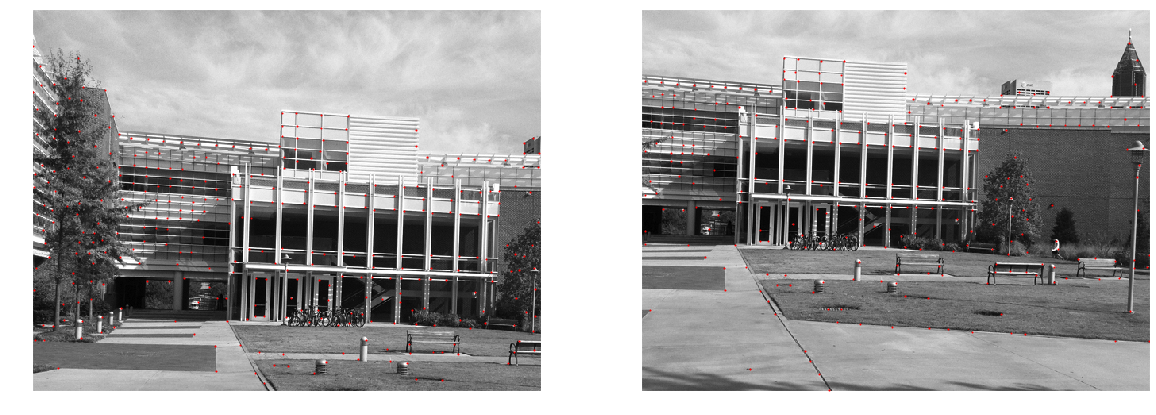

In [163]:
# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Image 1
transA_hc = harris_corners(transA, thresh=0.0001)
ax1.imshow(transA)
ax1.plot(transA_hc[1], transA_hc[0], 'ro', ms=1)
ax1.axis('off')
# Image 2
transB_hc = harris_corners(transB, thresh=0.0001)
ax2.imshow(transB)
ax2.plot(transB_hc[1], transB_hc[0], 'ro', ms=1)
ax2.axis('off');

Number of interest points: 195
Number of interest points: 191


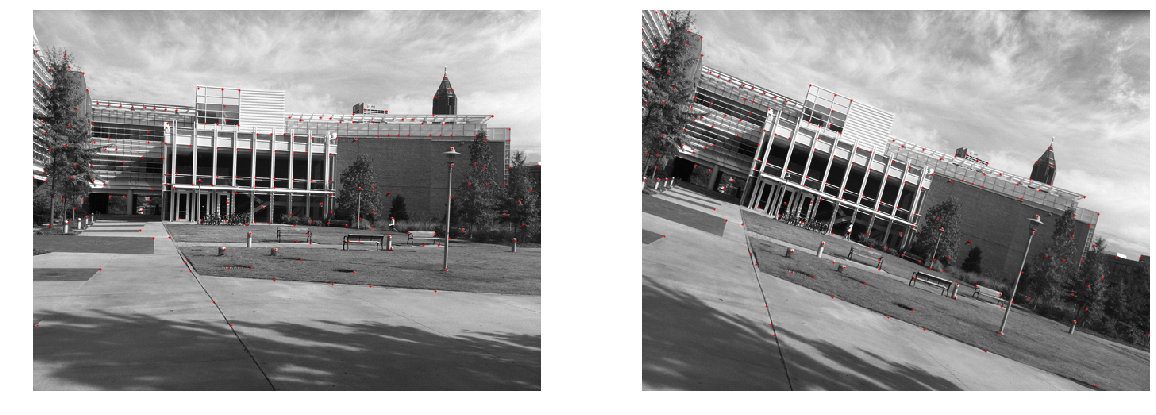

In [164]:
# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Image 1
simA_hc = harris_corners(simA, thresh=0.0001)
ax1.imshow(simA)
ax1.plot(simA_hc[1], simA_hc[0], 'ro', ms=1)
ax1.axis('off')
# Image 2
simB_hc = harris_corners(simB, thresh=0.0001)
ax2.imshow(simB)
ax2.plot(simB_hc[1], simB_hc[0], 'ro', ms=1)
ax2.axis('off');

---
## 2. SIFT features
### 2.1 Orientation

In [165]:
def corners_to_keypoints(img, corners):
    '''
    
    '''
    # Gradients
    Ix = gradX(img)
    Iy = gradY(img)
    # Orientation
    angle = np.arctan2(Iy, Ix)
    # OpenCV keypoints
    keypoints = [cv2.KeyPoint(x, y, 1, angle[y, x]) for y, x in zip(*corners)]
    return keypoints

def plot_keypoints(ax, keypoints):
    '''
    
    '''
    def plot_angle(ax, x, y, angle, length=8):
        '''

        '''
        # End points
        xl = x - length*np.cos(angle)
        xr = x + length*np.cos(angle)   
        yl = y - length*np.sin(angle)
        yr = y + length*np.sin(angle)
        # Plot
        ax.plot([xl, xr], [yl, yr], 'r')
        ax.plot(x, y, 'lime', marker='o', ms=1)
        return
    # Fix plot size
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    # Iterate all keypoints
    for kp in keypoints:
        x, y = kp.pt
        angle = kp.angle
        plot_angle(ax, x, y, angle)
    return

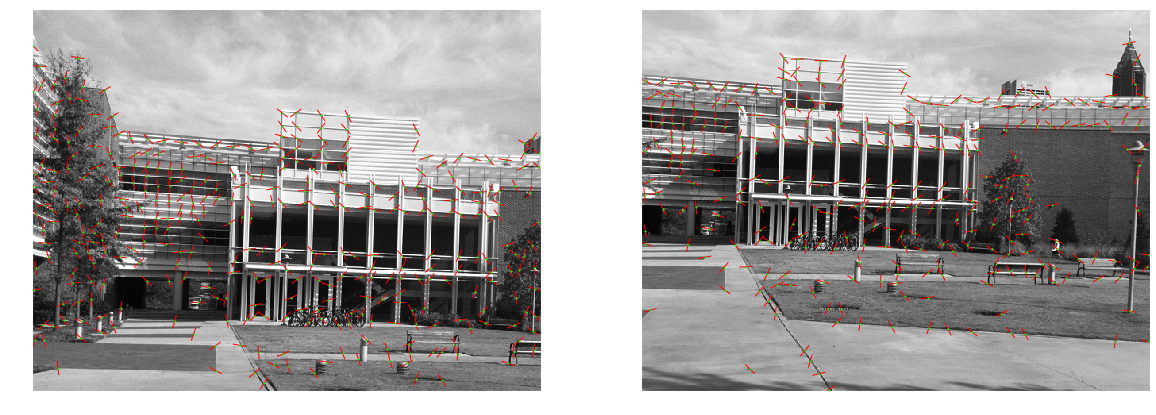

In [166]:
# Plots
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Image 1
ax1.imshow(transA)
ax1.axis('off')
## Keypoints
transA_kp = corners_to_keypoints(transA, transA_hc)
plot_keypoints(ax1, transA_kp)
# Image 2
ax2.imshow(transB)
ax2.axis('off')
## Keypoints
transB_kp = corners_to_keypoints(transB, transB_hc)
plot_keypoints(ax2, transB_kp)

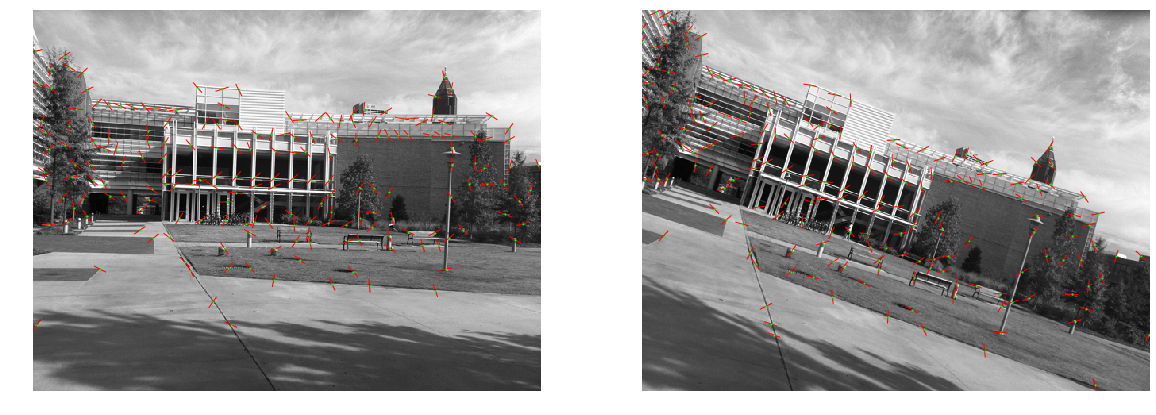

In [167]:
# Plots
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Image 1
ax1.imshow(simA)
ax1.axis('off')
## Keypoints
simA_kp = corners_to_keypoints(simA, simA_hc)
plot_keypoints(ax1, simA_kp)
# Image 2
ax2.imshow(simB)
ax2.axis('off')
## Keypoints
simB_kp = corners_to_keypoints(simB, simB_hc)
plot_keypoints(ax2, simB_kp)

### 2.2 Putative Pair

In [202]:
# Apply ratio test
def filter_matches(matches, ratio=0.75):
    good = []
    for m, n in matches:
        if m.distance < ratio*n.distance:
            good.append(m)
    return good
def draw_matches(ax1, ax2, matches, keypointsA, keypointsB):
    print('Number of matches: {:d}'.format(len(matches)))
    for m in matches:
        ixA = m.queryIdx
        ixB = m.trainIdx
        xyA = keypointsA[ixA].pt
        xyB = keypointsB[ixB].pt
        color = np.random.rand(3)
        ax1.plot(*xyA, marker='o', c=color, fillstyle='none')
        ax2.plot(*xyB, marker='o', c=color, fillstyle='none')
        con = ConnectionPatch(xyB, xyA, "data", "data", axesA=ax2, axesB=ax1, color=color)
        ax2.add_artist(con)
    return

In [203]:
# SIFT descriptor
sift = cv2.xfeatures2d.SIFT_create()
_, desA = sift.compute(transA_u8, transA_kp)
_, desB = sift.compute(transB_u8, transB_kp)
# BFMatcher with default params
bf = cv2.BFMatcher()

Number of matches: 129


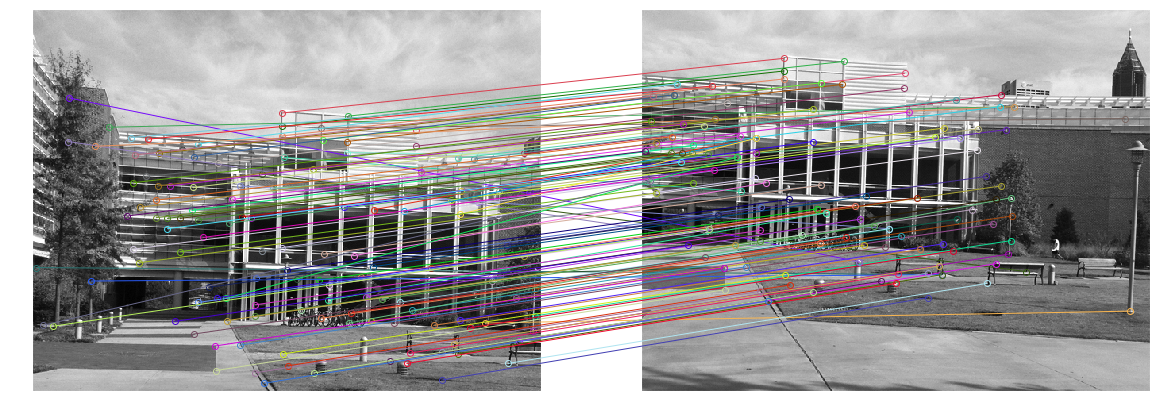

In [204]:
# Plots
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Image 1
ax1.imshow(transA)
ax1.axis('off')
# Image 2
ax2.imshow(transB)
ax2.axis('off')
trans_matches = bf.knnMatch(desA, desB, k=2)
trans_matches = filter_matches(trans_matches)
draw_matches(ax1, ax2, trans_matches, transA_kp, transB_kp)

In [205]:
# SIFT descriptor
sift = cv2.xfeatures2d.SIFT_create()
_, desA = sift.compute(simA_u8, simA_kp)
_, desB = sift.compute(simB_u8, simB_kp)
# BFMatcher with default params
bf = cv2.BFMatcher()

Number of matches: 38


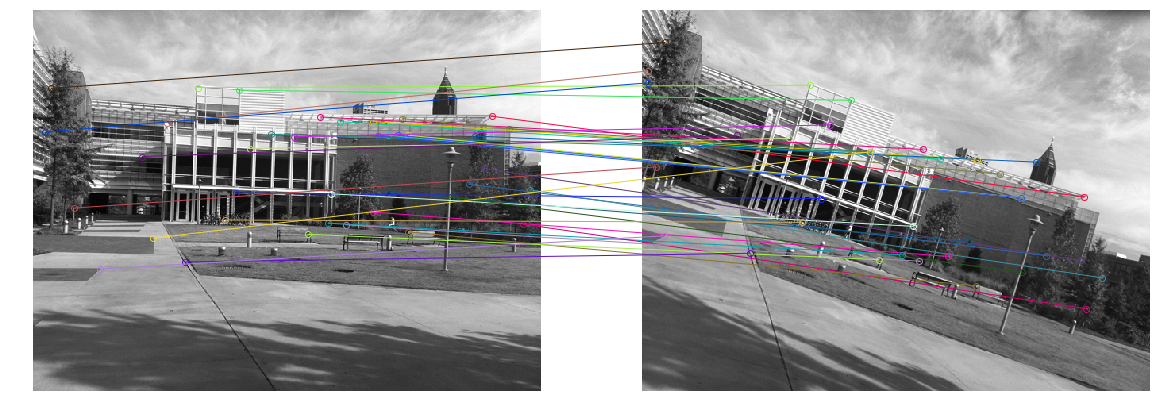

In [206]:
# Plots
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Image 1
ax1.imshow(simA)
ax1.axis('off')
# Image 2
ax2.imshow(simB)
ax2.axis('off')
sim_matches = bf.knnMatch(desA, desB, k=2)
sim_matches = filter_matches(sim_matches)
draw_matches(ax1, ax2, sim_matches, simA_kp, simB_kp)

---
## 3. RANSAC
### 3.1 Tranlsation Image

In [263]:
num_iter = 100
tolerance = 30
max_matches = 0
for _ in range(num_iter):
    m = np.random.choice(trans_matches, 1).item()
    ixA = m.queryIdx
    ixB = m.trainIdx
    xyA = np.array(transA_kp[ixA].pt)
    xyB = np.array(transB_kp[ixB].pt)
    t = xyB - xyA
    inliers = []
    t_inliers = []
    for msample in trans_matches:
        ixA = msample.queryIdx
        ixB = msample.trainIdx
        xyA = np.array(transA_kp[ixA].pt)
        xyB = np.array(transB_kp[ixB].pt)
        error = (xyA + t) - xyB
        if np.linalg.norm(error) < tolerance:
            tsample = xyB - xyA
            t_inliers.append([tsample])
            inliers.append(msample) 
    if len(inliers) > max_matches:
        max_matches = len(inliers)
        matches_best = inliers
        t_best = np.squeeze(np.mean(t_inliers, axis=0))

Translation Vector:               [-142.41237113  -88.02061856]
Percentage of consistent matches: 75.19%
Number of matches: 97


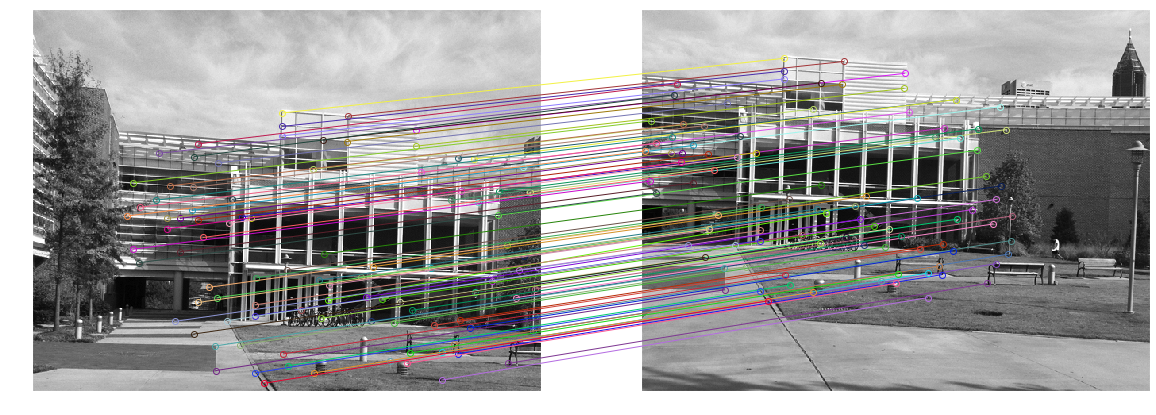

In [264]:
print('Translation Vector:              ', t_best)
print('Percentage of consistent matches: {:.2f}%'.format(100*max_matches/len(trans_matches)))
# Plots
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Image 1
ax1.imshow(transA)
ax1.axis('off')
# Image 2
ax2.imshow(transB)
ax2.axis('off')
# Plot matches
draw_matches(ax1, ax2, matches_best, transA_kp, transB_kp)

### 3.2 Rotation Image

In [265]:
num_iter = 100
tolerance = 20
max_matches = 0
for _ in range(num_iter):
    m1, m2 = np.random.choice(sim_matches, 2, replace=False)
    ix1A = m1.queryIdx
    ix1B = m1.trainIdx
    x1A, y1A = simA_kp[ix1A].pt
    x1B, y1B = simB_kp[ix1B].pt
    ix2A = m2.queryIdx
    ix2B = m2.trainIdx
    x2A, y2A = simA_kp[ix2A].pt
    x2B, y2B = simB_kp[ix2B].pt
    A = np.array([[x1A, -y1A, 1, 0],
                  [y1A,  x1A, 0, 1],
                  [x2A, -y2A, 1, 0],
                  [y2A,  x2A, 0, 1]])
    b = np.array([x1B, y1B, x2B, y2B])
    x = np.linalg.solve(A, b)
    T = np.array([[x[0], -x[1], x[2]],
                  [x[1],  x[0], x[3]]])
    inliers = []
    for msample in sim_matches:
        ixA = msample.queryIdx
        ixB = msample.trainIdx
        xyA = np.array(simA_kp[ixA].pt)
        xyA = np.append(xyA, 1)
        xyB = np.array(simB_kp[ixB].pt)
        error = T@xyA - xyB
        if np.linalg.norm(error) < tolerance:
            inliers.append(msample) 
    if len(inliers) > max_matches:
        max_matches = len(inliers)
        matches_best = inliers

num_variables = 4
A = np.zeros((2*max_matches, num_variables), dtype=np.float)
b = np.zeros((2*max_matches), dtype=np.float)
for ix, m in enumerate(matches_best):
    ixA = m.queryIdx
    ixB = m.trainIdx
    xA, yA = simA_kp[ixA].pt
    xB, yB = simB_kp[ixB].pt
    A[2*ix,   :] = [xA, -yA, 1, 0]
    A[2*ix+1, :] = [yA,  xA, 0, 1]
    b[2*ix]      =  xB
    b[2*ix+1]    =  yB

x = np.linalg.lstsq(A, b, rcond=None)[0]
T = np.array([[x[0], -x[1], x[2]],
              [x[1],  x[0], x[3]]])

Similarity transformation:
[[  0.9790398   -0.29055397  39.70681765]
 [  0.29055397   0.9790398  -61.80944254]]
Percentage of consistent matches: 76.32%
Number of matches: 29


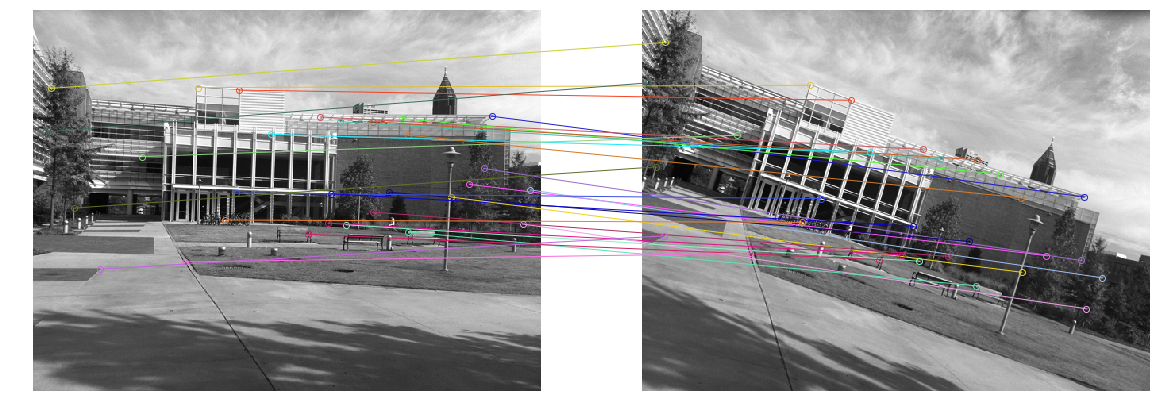

In [266]:
print('Similarity transformation:')
print(T)
print('Percentage of consistent matches: {:.2f}%'.format(100*max_matches/len(sim_matches)))
# Plots
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Image 1
ax1.imshow(simA)
ax1.axis('off')
# Image 2
ax2.imshow(simB)
ax2.axis('off')
# Plot matches
draw_matches(ax1, ax2, matches_best, simA_kp, simB_kp)